In [87]:
!pip install langgraph langchain langsmith langchain_groq langchain_community
!pip install arxiv
!pip install wikipedia

In [88]:
from typing import Annotated
from typing_extensions import TypedDict

In [89]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [90]:
wiki_tool.invoke("Who is Sachin Tendulkar?")

"Page: Sachin Tendulkar\nSummary: Sachin Ramesh Tendulkar ( ; pronounced [sətɕin teːɳɖulkəɾ]; born 24 April 1973) is an Indian former international cricketer who captained the Indian national team. He is widely regarded as one of the greatest batsmen in the history of cricket. Hailed as the world's mo"

In [91]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [92]:
tools = [wiki_tool]

In [93]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages: Annotated[list,add_messages]

In [94]:
from langgraph.graph import StateGraph,START,END
graph_builder = StateGraph(State)

In [95]:
from google.colab import userdata
groq_api_key = userdata.get('groq_api_key')

In [96]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x783912422b30>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7839124220b0>, model_name='Gemma2-9b-It', groq_api_key=SecretStr('**********'))

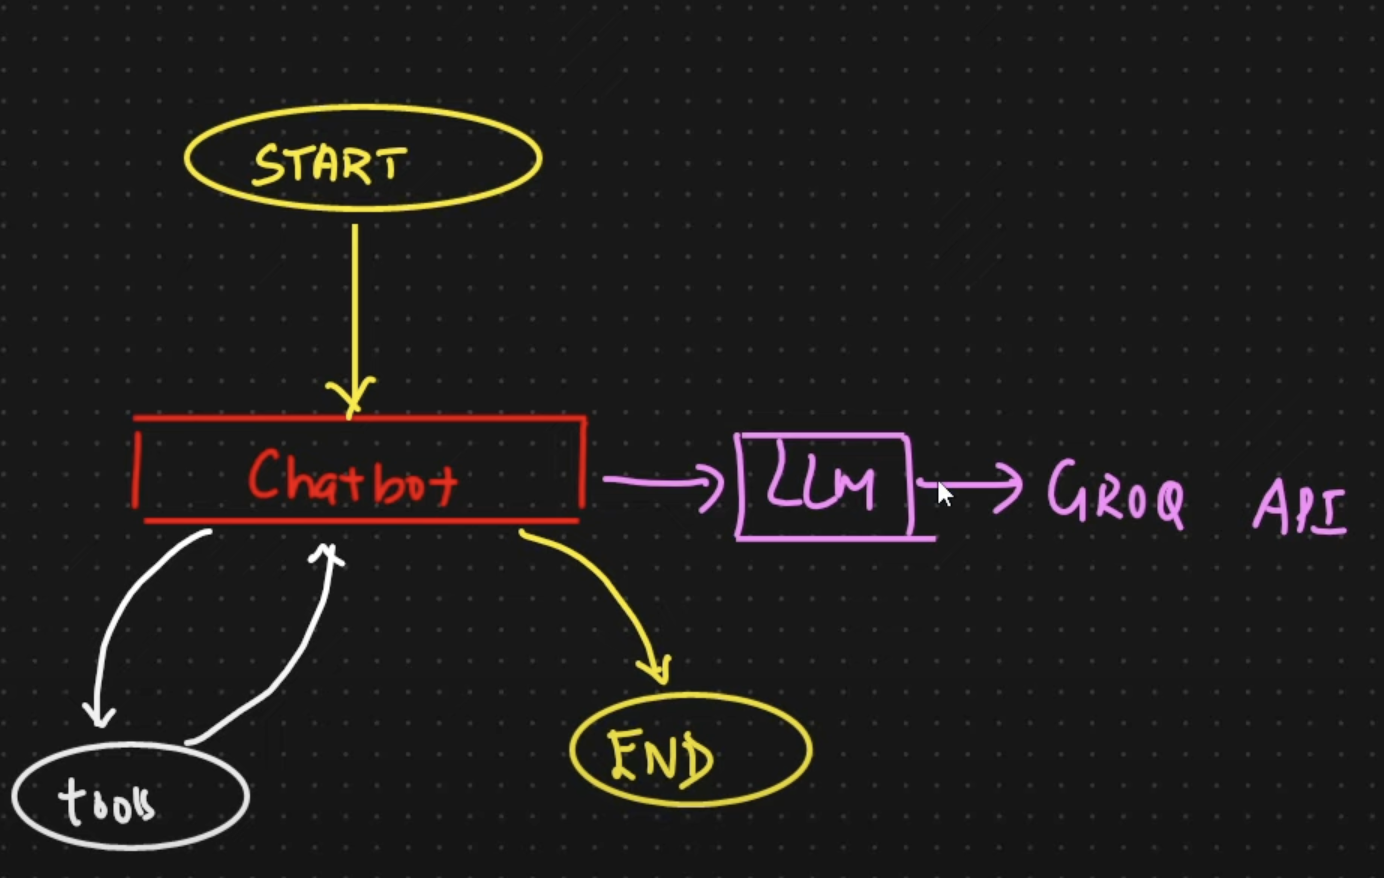

- LLM Groq Api thing is done now we need to work on Chatbot

In [97]:
llm_with_tools=llm.bind_tools(tools=tools)

In [98]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

Chatbot is also ready now

In [99]:
from langgraph.prebuilt import ToolNode,tools_condition

In [100]:
#Now lets create teh Flow
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

#Add conditional Node
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [101]:
graph=graph_builder.compile()

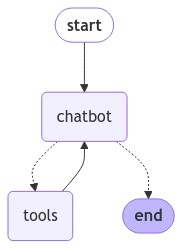

In [103]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [105]:
user_input="Hi there!, My name is Amitabh Bachan"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is Amitabh Bachan
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_2m37)
 Call ID: call_2m37
  Args:
    query: Amitabh Bachan
================================= Tool Message =================================
Name: wikipedia

Page: Amitabh Bachchan
Summary: Amitabh Bachchan (pronounced [əmɪˈt̪ɑːbʱ ˈbətːʃən] ; born Amitabh Srivastava; 11 October 1942) is an Indian actor who works in Hindi cinema. He is considered among the greatest and most accomplished actors in the history of Indian cinema. With a cinematic career spann
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_549k)
 Call ID: call_549k
  Args:
    query: Amitabh Bachchan career span
================================= Tool Message =================================
Name: wikipedia

Page: Amitabh Bachchan
Summa

In [106]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_mqn0)
 Call ID: call_mqn0
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other models to perform tasks that are aligned wi